# Overview


## Package loading


In [1]:
# Standard packages
import grama as gr
DF = gr.Intention()
import pandas as pd
import numpy as np
import time
import warnings
# Custom boat analysis package
from boats import *
# Archival data
filename_samples = "data/stability-proc.csv"
# Configure jupyter inline visuals
%matplotlib inline

/home/zach/Git/py_grama/grama/eval_defaults.py:228: SyntaxWarning: "is" with a literal. Did you mean "=="?


# Boat stability physics

A boat is not guaranteed to rotate back to its upright position. For a boat to be upright-stable, the centers of buoyancy (COB) and mass (COM) must move in such a way as to create a restoring torque. 

The following boat hull design acheives a restoring torque at small angles. This is an upright-stable design.

![Stable boat](../images/hull-schematic-stable.png)

The following boat hull design experiences an anti-restoring torque at small angles. This is an upright-unstable design.

![Unstable boat](../images/hull-schematic-unstable.png)

Our goal in this work is to understand how the design of the boat hull (cross-section) affects upright stability. Naval engineers use the concept of *statical stability* to study this problem.

## Statical stability

Statical stability is defined under certain artificial---but useful---assumptions:

- The boat has zero velocity; it has no momentum that can capsize the vessel.
- The boat is at an *equilibrium heave*; this means it is at a depth where the magnitude of the buoyant force exactly equals the vessel's weight.
- The moment is measured at a range of *roll angles*. The boat is assumed to start from zero velocity and equilibrium heave at each of these angles.

The moment computed according to this approach is then the initial torque experienced in a dynamic setting. The following image depicts a statical stability curve for a single boat design. Note that counter-clockwise rotation corresponds to the $+\theta$ direction, following standard mathematics notation.

![Statical stability moment curve](../images/moment-curve.png)

A boat design's upright stability can be determined from this moment curve $M(\theta)$. For upright stability, there must be a restoring torque at small angles $\theta \to 0^{\circ}$. For $\theta > 0^{\circ}$, the moment must be negative to oppose the direction of rotation. For a continuous moment curve, this corresponds to a negative slope of the moment curve at $\theta = 0^{\circ}$. Thus, we can use $\left.\frac{dM}{d\theta}\right|_{\theta=0^{\circ}}$ as an indicator of stability.


# Computational Model

Rather than use mathematical analysis to derive an exact expression for $M(\theta)$, we will use a computational approach to approximate a solution. This will allow us to study a wider variety of boat geometries than we could analyze via pencil and paper alone. This approach will require us to both build a computational model, and use a computational approach to analyze that model.


## Shape parameterization

We parameterize a family of boat hull designs using a simple expression. The following expression defines the lower bound of the boat hull

$$f_{\text{bot.}}(x) = H | \frac{2x}{W} |^n,$$

where $H$ is the height of the boat, $W$ is its (full) width, and $n$ defines the sharpness of its lower corner. The hull is then defined by the region in the $x,y$ plane bounded between

$$f_{\text{bot.}}(x) \leq y \leq H,$$

for all $-W/2 \leq x \leq +W/2$. The following image depicts an example boat hull with $H=2, W=3, n=1$.

![](images/hull-schematic-upright.png)

The COB is fully determined by the boat geometry $H,W,n$, its orientation $\theta$, and heave (which defines the location of the waterline across the boat). However, two more quantities are necessary to solve for the moment curve $M(\theta)$. 

The mass of the boat $m_{\text{boat}}$ must be known in order to enforce the conditions of statical stability. We express the mass of the boat as the *displacement ratio* $d = m_{\text{boat}} / (V_{\text{disp. max}} \times \rho_{\text{water}})$, where $V_{\text{disp. max}}$ is the *maximum* volume of water the boat can displace (e.g., when fully submerged), and $\rho_{\text{water}}$ is the mass density of water.

The center of mass (COM) of the boat is not necessarily at its centroid, as real boats are designed with heavy weights to lower their COM. We will express this design freedom by defining the COM location to be $y_{COM} = f_{COM} H$, with $f_{COM}$ controlling the COM location as a fraction of the overall boat height.


## Mathematical formulation

Vessel displacement

$$V_{\text{disp.}}(y_w) = \int_{x=-W/2}^{+W/2} \int_{f_{\text{bot.}}(x)}^{y_w} dx dy,$$

based on waterline location $y_w$. Equilibrium heave: solve for $y_w^*$ such that $V_{\text{disp.}}(y_w^*) = d V_{\text{disp. max}}$. Can be found via rootfinding

Moment curve

$$M(\theta) = (m_{\text{boat}} g) (x_{COB} - x_{COM}),$$

Where $g$ is the acceleration due to gravity and $m_{\text{boat}}$ can be determined from the displacement ratio $d$.

Center locations

$$x_{COB} = \int_{x=-W/2}^{+W/2} \int_{f_{\text{bot.}}(x)}^{y_w} x dx dy.$$

$$x_{COM} = \int_{x=-W/2}^{+W/2} \int_{f_{\text{bot.}}(x)}^{H} x dx dy.$$

The integrals above can be approximated using a discrete approximation.


## Discrete integral approximation

TODO


## Computational approach

Provide boat parameterization $H, W, n, d, f_{COM}$

1. Rotate boat to desired angle $\theta$
2. Solve for equilibrium waterline location $y_w$ at angle $\theta$
3. Compute center of buoyancy location $x_{COB}$
4. Compute moment at angle $M(\theta)$
5. Return to Step 1 until all desired angles are analyzed


## Implement the model

The computational approach described above is implemented in the provided `boat_utils.py` file. The following code load the boat analysis code.


In [2]:
md_performance = (
    gr.Model("Boat Performance Characteristics")
    >> gr.cp_function(
        fun=fun_performance,
        var=["H", "W", "n", "d", "f_com"],
        out=[
            "mass",
            "BM",
            "GM",
            "angle",
            "dMdtheta_0",
            "dMdtheta_avs", 
            "M_max", 
            "M_min", 
            "int_M_stable",
        ],
        runtime=1.27,
    )
    >> gr.cp_marginals(
        H=dict(dist="uniform", loc=1, scale=2),
        W=dict(dist="uniform", loc=1, scale=3),
        n=dict(dist="uniform", loc=0.5, scale=1.0),
        d=dict(dist="uniform", loc=0.25, scale=0.50),
        f_com=dict(dist="uniform", loc=0.10, scale=0.90),
    )
    >> gr.cp_copula_independence()
)
md_performance

model: Boat Performance Characteristics

  inputs:
    var_det:

    var_rand:
      H: (+0) uniform, {'mean': '2.000e+00', 's.d.': '5.800e-01', 'COV': 0.29, 'skew.': 0.0, 'kurt.': 1.8}
      W: (+0) uniform, {'mean': '2.500e+00', 's.d.': '8.700e-01', 'COV': 0.35, 'skew.': 0.0, 'kurt.': 1.8}
      n: (+0) uniform, {'mean': '1.000e+00', 's.d.': '2.900e-01', 'COV': 0.29, 'skew.': 0.0, 'kurt.': 1.8}
      d: (+0) uniform, {'mean': '5.000e-01', 's.d.': '1.400e-01', 'COV': 0.29, 'skew.': 0.0, 'kurt.': 1.8}
      f_com: (+0) uniform, {'mean': '5.500e-01', 's.d.': '2.600e-01', 'COV': 0.47, 'skew.': 0.0, 'kurt.': 1.8}

    copula:
      Independence copula

  functions:
      f0: ['H', 'W', 'n', 'd', 'f_com'] -> ['mass', 'BM', 'GM', 'angle', 'dMdtheta_0', 'dMdtheta_avs', 'M_max', 'M_min', 'int_M_stable']

Now that we have *implemented* the computational model, we can use additional computational techniques to *analyze* the model in order to understand its behavior.


# Computational Analysis


## Load the archival data

I pre-computed stability results for $1000$ random boat designs. We can use these as an initial sample to understand rough trends in boat design.


In [3]:
filename = "data/stability-proc.csv"
df_data = pd.read_csv(filename)
df_data

,d,n,f_com,H,W,M_max,mass,dMdtheta_avs,dMdtheta_0,M_min,BM,angle,int_M_stable,GM,stability
0,0.414694,0.969522,0.384112,1.931260,1.390651,5.004726e-16,0.019592,NaN,-1.459991,-4.952630e+00,0.108234,180.000000,-8.019885,0.193949,74.519812
1,0.242507,1.195436,0.656740,2.713299,3.580954,7.277457e+00,0.046730,NaN,9.916728,-5.402567e+00,0.425216,0.000000,3.675911,-0.557773,-212.215489
2,0.441223,0.936345,0.672138,1.446188,3.744617,6.550768e+00,0.040910,8.237037,-11.668754,-5.879390e+00,1.073773,92.654593,-5.681558,0.768485,285.230889
3,0.689483,0.882652,0.648739,1.210221,2.530339,1.149756e+00,0.034526,2.380926,-8.409095,-2.228434e+00,0.764303,86.466261,-2.070254,0.652657,243.556979
4,0.497305,0.780804,0.235978,2.502149,1.505777,7.886234e-16,0.029039,NaN,-8.644337,-1.401972e+01,0.103794,180.000000,-25.533024,0.796536,297.684552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.277591,0.562650,0.893968,2.662832,3.030807,5.471222e+00,0.028587,NaN,9.738265,-6.066334e-16,0.233400,0.000000,11.236121,-0.907202,-340.654998
996,0.406322,1.403215,0.243989,1.820171,1.337757,6.824626e-16,0.021281,NaN,-2.759760,-6.680056e+00,0.113371,180.000000,-11.439189,0.366400,129.679332
997,0.607333,0.636330,0.390791,1.504778,3.372128,1.289096e-15,0.044168,NaN,-24.322574,-9.742923e+00,1.100546,180.000000,-17.504023,1.399712,550.683211
998,0.622833,0.751532,0.386794,2.306757,2.632218,1.910895e-15,0.059512,NaN,-19.836982,-1.574321e+01,0.424443,180.000000,-34.614643,0.877600,333.327660


## Input/Output Correlations

The following code computes the linear correlation between each design input $H, W, n, d, f_{COM}$ and the moment curve slope $\left.\frac{dM}{d\theta}\right|_{\theta=0^{\circ}}$.


Calling plot_corrtile....


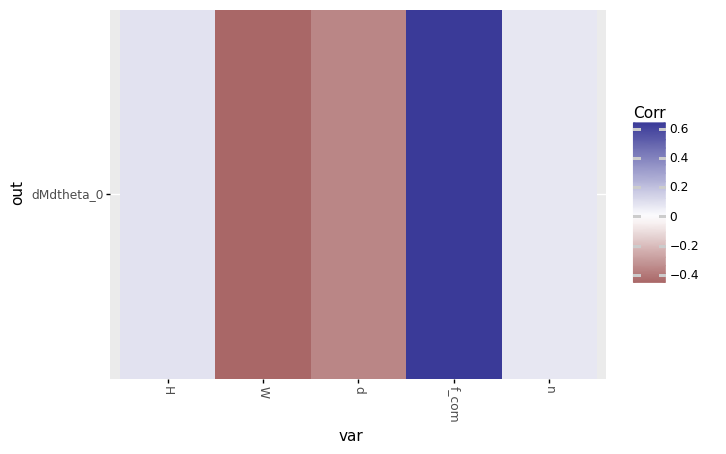

<ggplot: (8764677912308)>

In [4]:
(
    df_data
    >> gr.tf_iocorr(
        var=md_performance.var,
        out=["dMdtheta_0"],
    )
    >> gr.pt_auto()
)

Recall that $\left.\frac{dM}{d\theta}\right|_{\theta=0^{\circ}} < 0$ is necessary for upright stability. Therefore, we can interpret the correlation values in light of this slope:

- $H$ weak correlation
- $W$ strong negative correlation; increasing $W$ tends to increase stability
- $n$ weak correlation
- $d$ moderate negative correlation; increasing $d$ tends to increase stability
- $f_{COM}$ strong positive correlation; decreasing $f_{COM}$ tends to increase stability

## Parameter sweeps


### Describe the input space


Estimated runtime: 3.1750 min
Calling plot_sinew_inputs....


/home/zach/Git/py_grama/grama/plot_auto.py:413: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


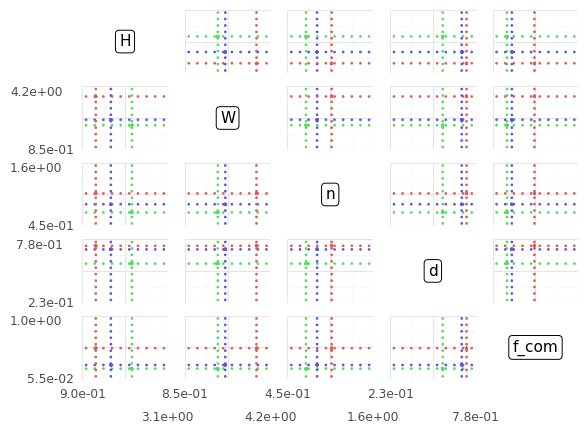

In [5]:
(
    md_performance
    >> gr.ev_sinews(df_det="swp", skip=True)
    >> gr.pt_auto()
)

### Generate sweep analysis


In [6]:
df_sweeps = (
    md_performance
    >> gr.ev_sinews(df_det="swp")
)

/home/zach/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


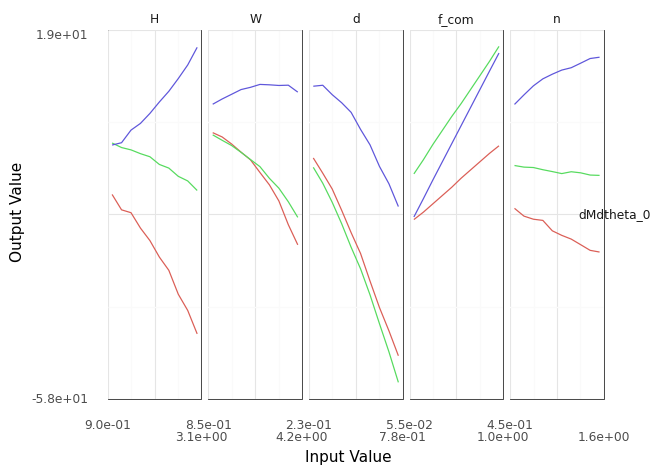

<ggplot: (8764678040061)>

In [7]:
(
    df_sweeps
    >> gr.pt_sinew_outputs(
        var=md_performance.var,
        out=["dMdtheta_0"]
    )
)